In [2]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import scipy.stats as sts
import numpy as np

F_dir = 'C:/Users/lonurmin/Desktop/AnalysisScripts/VariabilitySizeTuning/variability-sizetuning-analysis/'

amplification_DF = pd.read_csv(F_dir + 'amplification_DF_division.csv')
n_boots = 1000

Why some units show both amplification and quenching and some just quenching. Based on eye balling the data, it seemed that units with high baseline fano-factor show quenching. Let's quantify that at the population. The analyses below show that indeed, units that show only quenching, have on average higher baseline variability.

Mean and SEM of bsl for each layer and quencher / mixer type:
layer  qtype_signi
G      mixer          1.544031
       quencher       1.668304
IG     mixer          1.446056
       quencher       2.415433
SG     mixer          2.202544
       quencher       3.712623
Name: bsl, dtype: float64
layer  qtype_signi
G      mixer          0.179315
       quencher       0.149879
IG     mixer          0.070912
       quencher       0.282460
SG     mixer          0.300429
       quencher       0.339110
Name: bsl, dtype: float64
                  df     sum_sq    mean_sq          F    PR(>F)
C(qtype_signi)   1.0  20.737117  20.737117  23.175701  0.000007
C(layer)         2.0  24.845657  12.422828  13.883692  0.000007
Residual        78.0  69.792716   0.894778        NaN       NaN

Baseline difference between quencher and mixer in SG:
Ttest_indResult(statistic=-3.341177837218129, pvalue=0.0023075998204913645)

Baseline difference between quencher and mixer in G:
Ttest_indResult(statistic=-0.536052

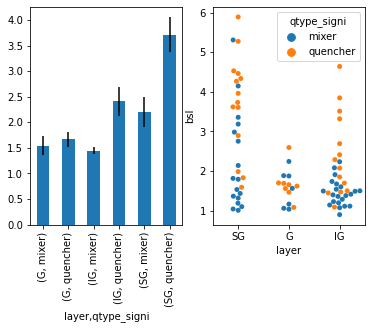

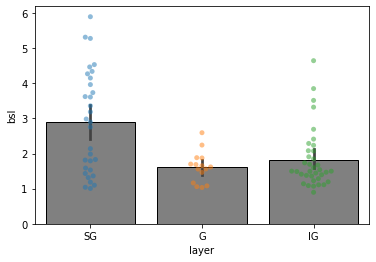

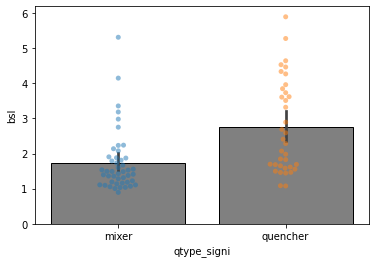

In [3]:
ax = plt.subplot(1,2,1)
SEM = amplification_DF.groupby(['layer','qtype_signi'])['bsl'].sem()
amplification_DF.groupby(['layer','qtype_signi'])['bsl'].mean().plot(kind='bar',yerr=SEM,ax=ax)

ax = plt.subplot(1,2,2)
sns.swarmplot(x='layer',y='bsl',data=amplification_DF,hue='qtype_signi',ax=ax)

plt.figure()
sns.barplot(y='bsl',x='layer',data=amplification_DF,fc='gray',ec='black')
sns.swarmplot(y='bsl',x='layer',data=amplification_DF,alpha=0.5)

plt.figure()
sns.barplot(y='bsl',x='qtype_signi',data=amplification_DF,fc='gray',ec='black')
sns.swarmplot(y='bsl',x='qtype_signi',data=amplification_DF,alpha=0.5)

print('Mean and SEM of bsl for each layer and quencher / mixer type:')
print(amplification_DF.groupby(['layer','qtype_signi'])['bsl'].mean())
print(amplification_DF.groupby(['layer','qtype_signi'])['bsl'].sem())

lm = ols('bsl ~ C(qtype_signi) + C(layer)',data=amplification_DF).fit()
table = sm.stats.anova_lm(lm,typ=1)
print(table)

SG = amplification_DF[amplification_DF['layer']=='SG']
G = amplification_DF[amplification_DF['layer']=='G']
IG = amplification_DF[amplification_DF['layer']=='IG']

print('\nBaseline difference between quencher and mixer in SG:')
#------------------------------------------------------------------------------
mixer = SG.query('qtype_signi=="mixer"')['bsl']
quencher = SG.query('qtype_signi=="quencher"')['bsl']
print(sts.ttest_ind(mixer,quencher,nan_policy='omit'))

print('\nBaseline difference between quencher and mixer in G:')
#------------------------------------------------------------------------------
mixer = G.query('qtype_signi=="mixer"')['bsl']
quencher = G.query('qtype_signi=="quencher"')['bsl']
print(sts.ttest_ind(mixer,quencher,nan_policy='omit'))

print('\nBaseline difference between quencher and mixer in IG:')
#------------------------------------------------------------------------------
mixer = IG.query('qtype_signi=="mixer"')['bsl']
quencher = IG.query('qtype_signi=="quencher"')['bsl']
print(sts.ttest_ind(mixer,quencher,nan_policy='omit'))

print('\nBaseline difference between quencher and mixer across layers:')
#------------------------------------------------------------------------------
mixer = amplification_DF.query('qtype_signi=="mixer"')['bsl']
quencher = amplification_DF.query('qtype_signi=="quencher"')['bsl']
print(sts.ttest_ind(mixer,quencher,nan_policy='omit'))
print('Mixer:',mixer.mean(),'+-',mixer.sem(),'Quencher:',quencher.mean(),'+-',quencher.sem())

print('\nBaseline difference between layers:')
#------------------------------------------------------------------------------
print('SG:',SG['bsl'].mean(),'+-',SG['bsl'].sem(),'\n','G:',G['bsl'].mean(),'+-',G['bsl'].sem(),'\nIG:',IG['bsl'].mean(),'+-',IG['bsl'].sem())

Next observation from looking at the raw data was that it seems that amplification happens at small stimulus diameter whereas quenching happens at somewhat larger diameter. Below we quantify this observation.

In [4]:
# brute force bootstrap median
n_boots = 9999
# stimulus diameter relative to RF at maxquench / maxmplif 
RFnormed_maxquench_diam = amplification_DF['maxquench_diam']/amplification_DF['RFdiam']
RFnormed_maxamplif_diam = amplification_DF['maxamplif_diam']/amplification_DF['RFdiam']
if 'RFnormed_maxquench_diam' not in amplification_DF.columns:
    amplification_DF['RFnormed_maxquench_diam'] = RFnormed_maxquench_diam
    amplification_DF['RFnormed_maxamplif_diam'] = RFnormed_maxamplif_diam


# stimulus diameter at maxquench / maxmplif 
SG = amplification_DF[amplification_DF['layer']=='SG']
SG = SG[~np.isnan(SG['maxamplif_diam'].values)]

G = amplification_DF[amplification_DF['layer']=='G']
G = G[~np.isnan(G['maxamplif_diam'].values)]

IG = amplification_DF[amplification_DF['layer']=='IG']
IG = IG[~np.isnan(IG['maxamplif_diam'].values)]

maxquench_diam_bootstrap = np.nan * np.ones(n_boots)
maxquench_diam_bootstrap_SG = np.nan * np.ones(n_boots)
maxquench_diam_bootstrap_G  = np.nan * np.ones(n_boots)
maxquench_diam_bootstrap_IG = np.nan * np.ones(n_boots)

maxamplif_diam_bootstrap = np.nan * np.ones(n_boots)
maxamplif_diam_bootstrap_SG = np.nan * np.ones(n_boots)
maxamplif_diam_bootstrap_G  = np.nan * np.ones(n_boots)
maxamplif_diam_bootstrap_IG = np.nan * np.ones(n_boots)

maxquench_diam_RFnormed_bootstrap = np.nan * np.ones(n_boots)
maxquench_diam_RFnormed_bootstrap_SG = np.nan * np.ones(n_boots)
maxquench_diam_RFnormed_bootstrap_G  = np.nan * np.ones(n_boots)
maxquench_diam_RFnormed_bootstrap_IG = np.nan * np.ones(n_boots)

maxamplif_diam_RFnormed_bootstrap = np.nan * np.ones(n_boots)
maxamplif_diam_RFnormed_bootstrap_SG = np.nan * np.ones(n_boots)
maxamplif_diam_RFnormed_bootstrap_G  = np.nan * np.ones(n_boots)
maxamplif_diam_RFnormed_bootstrap_IG = np.nan * np.ones(n_boots)


for i in range(n_boots):
    maxquench_diam_bootstrap = np.nanmedian(np.random.choice(amplification_DF['maxquench_diam'],size=len(amplification_DF),replace=True))
    maxquench_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(SG['maxquench_diam'],size=len(SG),replace=True))
    maxquench_diam_bootstrap_G[i]  = np.nanmedian(np.random.choice(G['maxquench_diam'],size=len(G),replace=True))
    maxquench_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(IG['maxquench_diam'],size=len(IG),replace=True))

    maxquench_diam_RFnormed_bootstrap = np.nanmedian(np.random.choice(amplification_DF['RFnormed_maxquench_diam'],size=len(amplification_DF),replace=True))
    maxquench_diam_RFnormed_bootstrap_SG[i] = np.nanmedian(np.random.choice(SG['RFnormed_maxquench_diam'],size=len(SG),replace=True))
    maxquench_diam_RFnormed_bootstrap_G[i]  = np.nanmedian(np.random.choice(G['RFnormed_maxquench_diam'],size=len(G),replace=True))
    maxquench_diam_RFnormed_bootstrap_IG[i] = np.nanmedian(np.random.choice(IG['RFnormed_maxquench_diam'],size=len(IG),replace=True))

    maxamplif_diam_bootstrap = np.nanmedian(np.random.choice(amplification_DF['maxamplif_diam'],size=len(amplification_DF),replace=True))
    maxamplif_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(SG['maxamplif_diam'],size=len(SG),replace=True))
    maxamplif_diam_bootstrap_G[i]  = np.nanmedian(np.random.choice(G['maxamplif_diam'],size=len(G),replace=True))
    maxamplif_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(IG['maxamplif_diam'],size=len(IG),replace=True))
    
    maxamplif_diam_RFnormed_bootstrap = np.nanmedian(np.random.choice(amplification_DF['RFnormed_maxamplif_diam'],size=len(amplification_DF),replace=True))
    maxamplif_diam_RFnormed_bootstrap_SG[i] = np.nanmedian(np.random.choice(SG['RFnormed_maxamplif_diam'],size=len(SG),replace=True))
    maxamplif_diam_RFnormed_bootstrap_G[i]  = np.nanmedian(np.random.choice(G['RFnormed_maxamplif_diam'],size=len(G),replace=True))
    maxamplif_diam_RFnormed_bootstrap_IG[i] = np.nanmedian(np.random.choice(IG['RFnormed_maxamplif_diam'],size=len(IG),replace=True))

maxquench_diam_SD = np.array([np.nanstd(maxquench_diam_bootstrap_SG),np.nanstd(maxquench_diam_bootstrap_G),np.nanstd(maxquench_diam_bootstrap_IG)])
maxquench_diam = np.array([np.nanmedian(SG['maxquench_diam']),np.nanmedian(G['maxquench_diam']),np.nanmedian(IG['maxquench_diam'])])

RFnormed_maxquench_diam_SD = np.array([np.nanstd(maxquench_diam_RFnormed_bootstrap_SG),np.nanstd(maxquench_diam_RFnormed_bootstrap_G),np.nanstd(maxquench_diam_RFnormed_bootstrap_IG)])
RFnormed_maxquench_diam = np.array([np.nanmedian(SG['RFnormed_maxquench_diam']),np.nanmedian(G['RFnormed_maxquench_diam']),np.nanmedian(IG['RFnormed_maxquench_diam'])])

maxamplif_diam_SD = np.array([np.nanstd(maxquench_diam_bootstrap_SG),np.nanstd(maxquench_diam_bootstrap_G),np.nanstd(maxquench_diam_bootstrap_IG)])
maxamplif_diam = np.array([np.nanmedian(SG['maxamplif_diam']),np.nanmedian(G['maxamplif_diam']),np.nanmedian(IG['maxamplif_diam'])])

RFnormed_maxamplif_diam_SD = np.array([np.nanstd(maxamplif_diam_RFnormed_bootstrap_SG),np.nanstd(maxamplif_diam_RFnormed_bootstrap_G),np.nanstd(maxamplif_diam_RFnormed_bootstrap_IG)])
RFnormed_maxamplif_diam = np.array([np.nanmedian(SG['RFnormed_maxamplif_diam']),np.nanmedian(G['RFnormed_maxamplif_diam']),np.nanmedian(IG['RFnormed_maxamplif_diam'])])

In [5]:
SG_selected_amplification_DF = pd.DataFrame({'RFnormed_maxamplif_diam':SG['RFnormed_maxamplif_diam'],'RFnormed_maxquench_diam':SG['RFnormed_maxquench_diam'],'layer':SG['layer']})
G_selected_amplification_DF = pd.DataFrame({'RFnormed_maxamplif_diam':G['RFnormed_maxamplif_diam'],'RFnormed_maxquench_diam':G['RFnormed_maxquench_diam'],'layer':G['layer']})
IG_selected_amplification_DF = pd.DataFrame({'RFnormed_maxamplif_diam':IG['RFnormed_maxamplif_diam'],'RFnormed_maxquench_diam':IG['RFnormed_maxquench_diam'],'layer':IG['layer']})

frames = [SG_selected_amplification_DF,G_selected_amplification_DF,IG_selected_amplification_DF]
selected_amplification_DF = pd.concat(frames)

[Text(1, 0, 'SG'), Text(3, 0, 'G'), Text(5, 0, 'IG')]

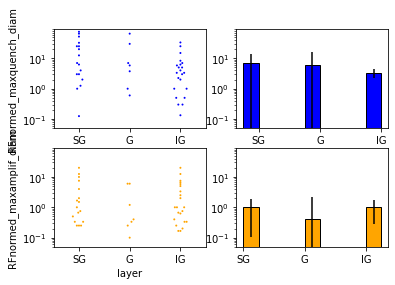

In [6]:
fig_dir   = 'C:/Users/lonurmin/Desktop/CorrelatedVariability/results/paper_v9/IntermediateFigures/'

SZZ = 2
ax = plt.subplot(2,2,1)
sns.swarmplot(x='layer',y='RFnormed_maxquench_diam',data=selected_amplification_DF,color='blue',ax=ax,size=SZZ)
ax.set_ylim([0.05,90])
ax.set_yscale('log')

ax = plt.subplot(2,2,2)
ax.bar([0.75,2.75,4.75],RFnormed_maxquench_diam,yerr=RFnormed_maxquench_diam_SD,fc='blue',ec='black',width=0.5)
ax.set_ylim([0.05,90])
ax.set_yscale('log')
ax.set_xticks([1,3,5])
ax.set_xticklabels(['SG','G','IG'])

ax = plt.subplot(2,2,3)
sns.swarmplot(x='layer',y='RFnormed_maxamplif_diam',data=selected_amplification_DF,color='orange',ax=ax,size=SZZ)
ax.set_ylim([0.05,90])
ax.set_yscale('log')

ax = plt.subplot(2,2,4)
ax.bar(np.array([0.75,2.75,4.75])+0.5,RFnormed_maxamplif_diam,yerr=RFnormed_maxamplif_diam_SD,fc='orange',ec='black',width=0.5)
ax.set_ylim([0.05,90])
ax.set_yscale('log')
ax.set_xticks([1,3,5])
ax.set_xticklabels(['SG','G','IG'])

#plt.savefig(fig_dir+'Figure_3C-amp_quench_diameters.svg')

In [7]:
import scipy.stats as stats

test_maxquench_diam_bootstrap_SG = np.nan * np.ones(n_boots)
test_maxamplif_diam_bootstrap_SG = np.nan * np.ones(n_boots)
test_maxquench_diam_bootstrap_G = np.nan * np.ones(n_boots)
test_maxamplif_diam_bootstrap_G = np.nan * np.ones(n_boots)
test_maxquench_diam_bootstrap_IG = np.nan * np.ones(n_boots)
test_maxamplif_diam_bootstrap_IG = np.nan * np.ones(n_boots)

RFnormed_test_maxquench_diam_bootstrap_SG = np.nan * np.ones(n_boots)
RFnormed_test_maxamplif_diam_bootstrap_SG = np.nan * np.ones(n_boots)
RFnormed_test_maxquench_diam_bootstrap_G = np.nan * np.ones(n_boots)
RFnormed_test_maxamplif_diam_bootstrap_G = np.nan * np.ones(n_boots)
RFnormed_test_maxquench_diam_bootstrap_IG = np.nan * np.ones(n_boots)
RFnormed_test_maxamplif_diam_bootstrap_IG = np.nan * np.ones(n_boots)

for i in range(n_boots):
    test_maxquench_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(np.concatenate((SG['maxquench_diam'],SG['maxamplif_diam'])),size=len(SG),replace=True))
    test_maxamplif_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(np.concatenate((SG['maxquench_diam'],SG['maxamplif_diam'])),size=len(SG),replace=True))
    RFnormed_test_maxquench_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(np.concatenate((SG['RFnormed_maxquench_diam'],SG['RFnormed_maxamplif_diam'])),size=len(SG),replace=True))
    RFnormed_test_maxamplif_diam_bootstrap_SG[i] = np.nanmedian(np.random.choice(np.concatenate((SG['RFnormed_maxquench_diam'],SG['RFnormed_maxamplif_diam'])),size=len(SG),replace=True))

    test_maxquench_diam_bootstrap_G[i] = np.nanmedian(np.random.choice(np.concatenate((G['maxquench_diam'],G['maxamplif_diam'])),size=len(G),replace=True))
    test_maxamplif_diam_bootstrap_G[i] = np.nanmedian(np.random.choice(np.concatenate((G['maxquench_diam'],G['maxamplif_diam'])),size=len(G),replace=True))
    RFnormed_test_maxquench_diam_bootstrap_G[i] = np.nanmedian(np.random.choice(np.concatenate((G['RFnormed_maxquench_diam'],G['RFnormed_maxamplif_diam'])),size=len(G),replace=True))
    RFnormed_test_maxamplif_diam_bootstrap_G[i] = np.nanmedian(np.random.choice(np.concatenate((G['RFnormed_maxquench_diam'],G['RFnormed_maxamplif_diam'])),size=len(G),replace=True))

    test_maxquench_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(np.concatenate((IG['maxquench_diam'],IG['maxamplif_diam'])),size=len(IG),replace=True))
    test_maxamplif_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(np.concatenate((IG['maxquench_diam'],IG['maxamplif_diam'])),size=len(IG),replace=True))
    RFnormed_test_maxquench_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(np.concatenate((IG['RFnormed_maxquench_diam'],IG['RFnormed_maxamplif_diam'])),size=len(IG),replace=True))
    RFnormed_test_maxamplif_diam_bootstrap_IG[i] = np.nanmedian(np.random.choice(np.concatenate((IG['RFnormed_maxquench_diam'],IG['RFnormed_maxamplif_diam'])),size=len(IG),replace=True))

SG_diff = test_maxquench_diam_bootstrap_SG - test_maxamplif_diam_bootstrap_SG
G_diff  = test_maxquench_diam_bootstrap_G - test_maxamplif_diam_bootstrap_G
IG_diff = test_maxquench_diam_bootstrap_IG - test_maxamplif_diam_bootstrap_IG

RFnormed_SG_diff = RFnormed_test_maxquench_diam_bootstrap_SG - RFnormed_test_maxamplif_diam_bootstrap_SG
RFnormed_G_diff = RFnormed_test_maxquench_diam_bootstrap_G - RFnormed_test_maxamplif_diam_bootstrap_G
RFnormed_IG_diff = RFnormed_test_maxquench_diam_bootstrap_IG - RFnormed_test_maxamplif_diam_bootstrap_IG

F = stats.cumfreq(SG_diff, numbins=2000)
x = F.lowerlimit + np.linspace(0, F.binsize*F.cumcount.size,F.cumcount.size)
ind = np.argmin(np.abs(x-(np.nanmedian(SG['maxquench_diam']) - np.nanmedian(SG['maxamplif_diam']))))
p = (F.cumcount/np.max(F.cumcount))[ind]
print('\nDifference of RFnormed medians in SG p = ', p)

F = stats.cumfreq(G_diff, numbins=2000)
x = F.lowerlimit + np.linspace(0, F.binsize*F.cumcount.size,F.cumcount.size)
ind = np.argmin(np.abs(x-(np.nanmedian(G['maxquench_diam']) - np.nanmedian(G['maxamplif_diam']))))
p = (F.cumcount/np.max(F.cumcount))[ind]
print('\nDifference of RFnormed medians in G p = ', p)

F = stats.cumfreq(IG_diff, numbins=2000)
x = F.lowerlimit + np.linspace(0, F.binsize*F.cumcount.size,F.cumcount.size)
ind = np.argmin(np.abs(x-(np.nanmedian(IG['maxquench_diam']) - np.nanmedian(IG['maxamplif_diam']))))
p = (F.cumcount/np.max(F.cumcount))[ind]
print('\nDifference of RFnormed medians in IG p = ', p)



Difference of RFnormed medians in SG p =  0.9941994199419942

Difference of RFnormed medians in G p =  0.8994899489948995

Difference of RFnormed medians in IG p =  0.9718971897189719


c:\Users\lonurmin\Miniconda3\envs\danalysis\lib\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
c:\Users\lonurmin\Miniconda3\envs\danalysis\lib\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


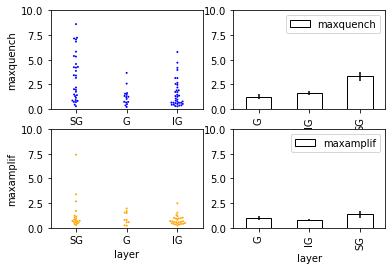

In [ ]:
plt.figure()
SZZ = 2
amplification_DF['maxquench'] = amplification_DF['maxquench']*-1

ax = plt.subplot(2,2,1)
sns.swarmplot(x='layer',y='maxquench',data=amplification_DF,color='blue',ax=ax,size=SZZ)
ax.set_ylim(0.1, 10)

ax = plt.subplot(2,2,2)
SEM = amplification_DF.groupby('layer')[['maxquench']].sem()
amplification_DF.groupby('layer')[['maxquench']].mean().plot(kind='bar',yerr=SEM,ax=ax,color='white',edgecolor='black')
ax.set_ylim(0, 10)

ax = plt.subplot(2,2,3)
sns.swarmplot(x='layer',y='maxamplif',data=amplification_DF,color='orange',ax=ax,size=SZZ)
ax.set_ylim(0, 10)

ax = plt.subplot(2,2,4)
SEM = amplification_DF.groupby('layer')[['maxamplif']].sem()
amplification_DF.groupby('layer')[['maxamplif']].mean().plot(kind='bar',yerr=SEM,ax=ax,color='white',edgecolor='black')
ax.set_ylim(0, 10)

plt.savefig(fig_dir+'Figure_3D-amp_quench_magnitudes.svg')

# just to make sure not to use the transformed data elsewhere
amplification_DF['maxquench'] = amplification_DF['maxquench']*-1

In [ ]:
lm = ols('maxquench ~ C(layer)',data=amplification_DF).fit()
table = sm.stats.anova_lm(lm,typ=1)
print('\n ANOVA over layers for maximum quenching amplitude:')
print(table)

lm = ols('maxamplif ~ C(layer)',data=amplification_DF).fit()
table = sm.stats.anova_lm(lm,typ=1)
print('\n ANOVA over layers for maximum amplification amplitude:')
print(table)




 ANOVA over layers for maximum quenching amplitude:
            df      sum_sq    mean_sq         F    PR(>F)
C(layer)   2.0   63.384457  31.692229  9.917686  0.000144
Residual  79.0  252.446596   3.195527       NaN       NaN

 ANOVA over layers for maximum amplification amplitude:
            df     sum_sq   mean_sq         F    PR(>F)
C(layer)   2.0   3.852022  1.926011  1.695896  0.193422
Residual  52.0  59.055855  1.135690       NaN       NaN
